# Optimal Number of Neurons

This is an example notebook for my blog post. This notebook gives an example of using the optimal number of neurons formula and shows how it can lead to good results. Of course this is _not_ a solution to _always_ give good results but from experiments I have ran it can be effective and helpful in deciding neural network size.

This example will only use one hidden layer, however Geoffrey Heaton has the following rules for selecting the number of layers.

| Number of Hidden Layers | Result                                                                                                                                                        |
|-------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| none                    | Only capable of representing linear separable functions or decisions.                                                                                         |
| 1                       | Can approximate any function that contains a continuous mapping from one finite space to another.                                                             |
| 2                       | Can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy. |
| >2                      | Additional layers can learn complex representations (sort of automatic feature engineering) for layer layers.                                                 |

However when it comes to neurons in hidden layers his advice is a bit more vague and gives the following advice:

1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.

This notebook will use the above advice and compare to the formula mentioned in the blog post.

## Experiment
The dataset used in this experiment is the dataset provided with the fastai tabular. This experiment attempts to show that Geoffrey Hinton's advice leads to a smaller choice in the number of neurons however when using the formula the model does not overfit anymore even though it is more complex.

For the formula in the blog post I will use two examples, letting $ \alpha = 2 $ and letting $ \alpha = 10 $.

In [1]:
from fastai.tabular import *
import pandas as pd
from fastai.tabular.all import *

### Data Importing and Setting Up

In [2]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/Users/henriwoodcock/.fastai/data/adult_sample/adult.csv'),Path('/Users/henriwoodcock/.fastai/data/adult_sample/export.pkl'),Path('/Users/henriwoodcock/.fastai/data/adult_sample/models')]

In [3]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [4]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [5]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [6]:
dls = to.dataloaders(bs=128)

### Prepare the data ready for fastai

## The number of hidden neurons should be between the size of the input layer and the size of the output layer.

In [7]:
input_layer = len(dls.x_names)
output_layer = len(dls.y_names)
print('The size of the input layer is:', input_layer)
print('The size of the output layer is:', output_layer)

The size of the input layer is: 10
The size of the output layer is: 1


For this example I will simply use the mid point of 1 and 21 as an integer.

In [8]:
number_of_neurons = (input_layer + output_layer)//2
print('The first model will use', number_of_neurons, 'neurons in the hidden layer')

The first model will use 5 neurons in the hidden layer


In [9]:
learn = tabular_learner(dls, layers = [number_of_neurons], metrics=accuracy)

In [10]:
learn.fit_one_cycle(10, lr_max = 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.371176,0.368102,0.827703,00:02
1,0.383056,0.378220,0.828931,00:02
2,0.389270,0.381653,0.825399,00:02
3,0.369640,0.365030,0.830160,00:02
4,0.388031,0.386035,0.812193,00:02
5,0.367889,0.375440,0.820178,00:02
6,0.368220,0.360477,0.834152,00:02
7,0.355878,0.359410,0.833845,00:02
8,0.363297,0.357576,0.835688,00:02
9,0.348290,0.354155,0.834613,00:02


In [11]:
print('accuracy =',learn.metrics[0].value)
print('loss =', learn.loss)

accuracy = tensor(0.8346)
loss = None


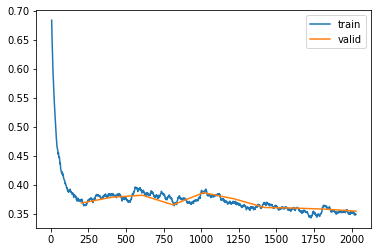

In [12]:
learn.recorder.plot_loss()

## The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.

In [13]:
input_layer = len(dls.x_names)
output_layer = len(dls.y_names)
print('The size of the input layer is:', input_layer)
print('The size of the output layer is:', output_layer)

The size of the input layer is: 10
The size of the output layer is: 1


In [14]:
number_of_neurons = int((2/3)*input_layer + output_layer)
print('The second model will use', number_of_neurons, 'neurons in the hidden layer')

The second model will use 7 neurons in the hidden layer


In [15]:
learn = tabular_learner(dls, layers = [number_of_neurons], metrics=accuracy)

In [16]:
learn.fit_one_cycle(10, lr_max = 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.367770,0.364098,0.830467,00:02
1,0.372729,0.369143,0.822021,00:02
2,0.376316,0.375687,0.826628,00:02
3,0.383349,0.393228,0.792998,00:02
4,0.368360,0.370843,0.826628,00:02
5,0.367377,0.362015,0.828471,00:02
6,0.366824,0.357100,0.830313,00:02
7,0.358947,0.355647,0.830313,00:02
8,0.357588,0.356825,0.831235,00:02
9,0.349893,0.355590,0.831235,00:02


In [17]:
print('accuracy =',learn.metrics[0].value)
print('loss =', learn.loss)

accuracy = tensor(0.8312)
loss = None


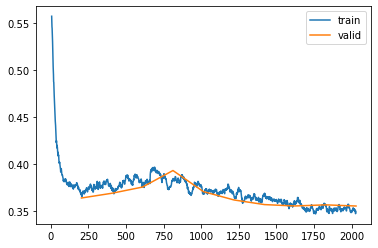

In [18]:
learn.recorder.plot_loss()

## The number of hidden neurons should be less than twice the size of the input layer.

In [19]:
input_layer = len(dls.x_names)
output_layer = len(dls.y_names)
print('The size of the input layer is:', input_layer)
print('The size of the output layer is:', output_layer)

The size of the input layer is: 10
The size of the output layer is: 1


In [20]:
number_of_neurons = input_layer//2
print('The first model will use', number_of_neurons, 'neurons in the hidden layer')

The first model will use 5 neurons in the hidden layer


In [21]:
learn = tabular_learner(dls, layers = [number_of_neurons], metrics=accuracy)

In [22]:
learn.fit_one_cycle(10, lr_max = 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.369844,0.370389,0.828778,00:02
1,0.374668,0.374356,0.816339,00:02
2,0.375929,0.374741,0.820025,00:02
3,0.370424,0.366250,0.827396,00:02
4,0.374238,0.376745,0.817260,00:02
5,0.371969,0.361549,0.825092,00:02
6,0.354615,0.381448,0.822942,00:02
7,0.357945,0.355139,0.835074,00:02
8,0.349837,0.353169,0.835842,00:02
9,0.347201,0.353491,0.835227,00:03


In [23]:
print('accuracy =',learn.metrics[0].value)
print('loss =', learn.loss)

accuracy = tensor(0.8352)
loss = None


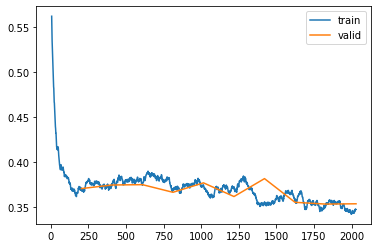

In [24]:
learn.recorder.plot_loss()

## Using the formula from the blog post

$$ N_{h} = \frac{N{s}}{\alpha (N_{i} + N_{o})} $$

First I will create a function to calculate $N_{h}$ from an alpha value

In [25]:
def calcHiddenLayer(data, alpha, numHiddenLayers):
    '''
    A function to calculate the optimal number of neurons.

    If multiple layers are wanted the function then splits the optimal number into a list of neurons. 
    This is just done by simply dividing neurons by number of layers
    '''
    i,o = len(data.x_names), len(data.y_names)
    io = i+o
    return [int((len(data.train_ds)//(alpha*(io)))//numHiddenLayers)]*numHiddenLayers

### Alpha = 2

In [26]:
input_layer = len(dls.x_names)
output_layer = len(dls.y_names)
print('The size of the input layer is:', input_layer)
print('The size of the output layer is:', output_layer)

The size of the input layer is: 10
The size of the output layer is: 1


In [27]:
alpha = 2
number_of_neurons = calcHiddenLayer(dls, alpha, 1)[0]
print('The fourth model will use', number_of_neurons, 'neurons in the hidden layer')

The fourth model will use 1184 neurons in the hidden layer


In [28]:
learn = tabular_learner(dls, layers = [number_of_neurons], metrics=accuracy)

In [29]:
learn.fit_one_cycle(10, lr_max = 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.385277,0.368907,0.828931,00:02
1,0.403563,0.384758,0.827088,00:02
2,0.416005,0.404154,0.806665,00:02
3,0.409184,0.383596,0.826321,00:02
4,0.388354,0.377243,0.831081,00:03
5,0.377576,0.364153,0.828010,00:03
6,0.366925,0.363768,0.829545,00:02
7,0.362193,0.359422,0.828163,00:02
8,0.356778,0.351546,0.832463,00:02
9,0.352887,0.351296,0.833999,00:02


In [30]:
print('accuracy =',learn.metrics[0].value)
print('loss =', learn.loss)

accuracy = tensor(0.8340)
loss = None


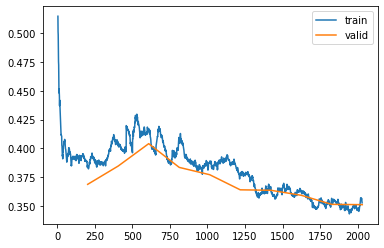

In [31]:
learn.recorder.plot_loss()

### alpha = 10

In [32]:
alpha = 10
number_of_neurons = calcHiddenLayer(dls, alpha, 1)[0]
print('The fifth model will use', number_of_neurons, 'neurons in the hidden layer')

The fifth model will use 236 neurons in the hidden layer


In [33]:
learn = tabular_learner(dls, layers = [number_of_neurons], metrics=accuracy)

In [34]:
learn.fit_one_cycle(10, lr_max = 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.379697,0.367343,0.830160,00:02
1,0.392545,0.384333,0.818796,00:02
2,0.381640,0.365512,0.830467,00:02
3,0.378551,0.376941,0.822789,00:02
4,0.379131,0.376559,0.824324,00:02
5,0.368506,0.364340,0.832156,00:03
6,0.374791,0.366091,0.830774,00:03
7,0.358324,0.358213,0.834767,00:03
8,0.354665,0.355602,0.832924,00:02
9,0.347101,0.355280,0.832310,00:02


In [35]:
print('accuracy =',learn.metrics[0].value)
print('loss =', learn.loss)

accuracy = tensor(0.8323)
loss = None


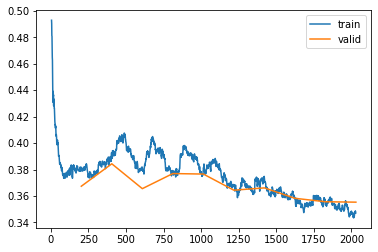

In [36]:
learn.recorder.plot_loss()

In [37]:
alpha = 6
number_of_neurons = calcHiddenLayer(dls, alpha, 1)[0]
print('The fifth model will use', number_of_neurons, 'neurons in the hidden layer')

The fifth model will use 394 neurons in the hidden layer


In [38]:
learn = tabular_learner(dls, layers = [number_of_neurons], metrics=accuracy)

In [39]:
learn.fit_one_cycle(10, lr_max = 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.384934,0.365354,0.830774,00:02
1,0.379249,0.395095,0.792537,00:02
2,0.372254,0.377950,0.823249,00:03
3,0.383462,0.401064,0.809736,00:03
4,0.387883,0.389513,0.818028,00:03
5,0.366532,0.362685,0.828317,00:02
6,0.368271,0.358914,0.830620,00:02
7,0.362988,0.356142,0.832617,00:02
8,0.360114,0.354594,0.832310,00:03
9,0.353618,0.353577,0.832770,00:03


In [44]:
print('accuracy =',learn.metrics[0].value)
print('loss =', learn.loss)

accuracy = tensor(0.8328)
loss = None


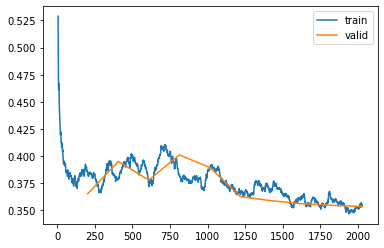

In [45]:
learn.recorder.plot_loss()

## Conclusion and Results

In [43]:
print("Difference in loss for model 1", 0.354155-0.348290)
print("Difference in loss for model 2", 0.355590-0.349893)
print("Difference in loss for model 3", 0.353491-0.347201)
print("Difference in loss for model 4", 0.351296-0.352887)
print("Difference in loss for model 5", 0.355280-0.347101)
print("Difference in loss for model 6", 0.353618-0.353577)

Difference in loss for model 1 0.005865000000000009
Difference in loss for model 2 0.005697000000000008
Difference in loss for model 3 0.006290000000000018
Difference in loss for model 4 -0.001591000000000009
Difference in loss for model 5 0.008178999999999992
Difference in loss for model 6 4.100000000001325e-05


As can be seen in the above results, the last 3 models (using the formula) have a smaller difference in the training and validation loss showing that the models are not overfitting and are infact fitting with the training data.

This could mean that with more training time these more complex models can increase the accuracy for both the training and validation set.